In [326]:
import gym
import matplotlib.pyplot as plt
from scipy.misc import imresize

#env = gym.make('SpaceInvaders-v0')
env = gym.make('CartPole-v0')


obs = env.reset()
obs_rec = []
action = 3

# 0 動かない
# 1 その場でショット
# 2 右
# 3 左
# 4 右行きながらショット
# 5 左行きながらショット

# while True:
#     env.render()
#     obs,reward,done,info = env.step(action)
#     obs_rec.append(obs)
#     if done == True:
#         break

import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

#env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
#env.render()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space: Box(4,)
action space: Discrete(2)
initial observation: [ 0.00199298 -0.04141417 -0.01257345  0.0030881 ]
next observation: [ 0.0011647   0.15388583 -0.01251169 -0.29353523]
reward: 1.0
done: False
info: {}


In [327]:
from collections import deque

In [328]:
from chainer import optimizers

In [329]:
class QFunction(chainer.Chain):

    def __init__(self, obs_size, n_actions, n_hidden_channels=10):
        super().__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_hidden_channels)
            self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)
            self.l2 = L.Linear(n_hidden_channels, n_hidden_channels)
            self.l3 = L.Linear(n_hidden_channels, n_actions)

    def __call__(self, x):
        """
        Args:
            x (ndarray or chainer.Variable): An observation
            test (bool): a flag indicating whether it is in test mode
        """
        h = F.leaky_relu(self.l0(x))
        h = F.leaky_relu(self.l1(h))
        h = F.leaky_relu(self.l2(h))
        return self.l3(h)

In [330]:

class Qlearner():
    def __init__(self,n_obs,n_act,n_exp):
        self.eps = 0.5
        self.eps_deg = 0.00001
        self.n_act = n_act
        self.act_cand = np.arange(self.n_act)
        self.n_obs = n_obs
        self.model = QFunction(n_obs,n_act)
        self.opt = optimizers.RMSpropGraves(lr=0.00025, alpha=0.95, momentum=0.95, eps=0.0001)
        self.opt.setup(self.model)
        self.opt.add_hook(optimizer.GradientClipping(0.01))
        self.losses = []
        self.memory = Memory(n_exp)
        self.update_num = 0 
        
    
    def step(self,obs,explore=True):
        obs = self.preinput(obs)
        q = self.model(obs)
        if explore == True:
            if np.random.rand()>self.eps:
                act = F.argmax(q).data+0
            else:
                act = np.random.randint(self.n_act)
        else:
            act = F.argmax(q).data+0
        return q,act
    
    def preinput(self,obs):
        return np.expand_dims(obs,axis=0).astype(np.float32)

    def calc_loss(self,batch_size,learner_target):
        acts,obss,targets = self.memory.sample(batch_size,learner_target)
        loss = []
        for act,obs,target in zip(acts,obss,targets):
            q,_ = self.step(obs,explore=False)
            q_act = q[0,act]
            loss.append((q_act-target)**2)
        return loss
    
    def update(self,batch_size,learner_target):
        loss = self.calc_loss(batch_size,learner_target)
        loss_mean = 0
        for l in loss:
            loss_mean += l
        loss_mean/=batch_size 
        
        self.losses.append(loss_mean.data)
        
        self.model.cleargrads()
        loss_mean.backward()
        self.opt.update()

        self.update_num += 1
        self.eps = 0.1 + 0.9 / (1.0+self.update_num*0.01)
        
        self.return_priority(loss)
        
    def copy(self,learner_target):
        self.model.copyparams(learner_target.model)
    def return_priority(self,loss):
        loss_abs = [np.abs(l.data) for l in loss]
        for ii,p in zip(self.memory.idx,loss_abs):
            self.memory.buffer_priority[ii] = p

In [331]:
class Memory():
    def __init__(self,n_exp):
        self.maxlen = n_exp
        self.gamma = 0.99
        self.buffer = deque(maxlen = self.maxlen)
        self.buffer_priority = deque(maxlen = self.maxlen)
        self.max_priority = 1
        
    def append(self,exp):
        if len(self.buffer_priority)<10:
            self.max_priority = 1
        else:
            self.max_priority = np.max(self.buffer_priority)
        self.buffer.append(exp)
        self.buffer_priority.append(self.max_priority)
    def add(self,exps):
        if len(self.buffer_priority)<10:
            self.max_priority = 1
        else:
            self.max_priority = np.max(self.buffer_priority)
        for k in range(len(exps)):
            self.buffer.append(exps[k])
            self.buffer_priority.append(self.max_priority)
        
    def sample(self,batch_size,learner_target):        
        p = self.buffer_priority/np.sum(self.buffer_priority)
        self.idx = np.random.choice(range(len(self.buffer)),size = batch_size, p = p)
        exps = [self.buffer[ii] for ii in self.idx]
        
        targets = []
        obss = []
        acts = []
        for act,obs,obs_next,reward,done in exps:
            q_target,act_target = learner_target.step(obs_next)
            if done == False:
                target = reward + self.gamma * np.max(q_target.data) 
            elif done == True:
                target = reward
            acts.append(act)
            targets.append(target)
            obss.append(obs)
        return acts,obss,targets
            

In [332]:
def make_exp_multi(exps,n_multi_step):

    qs = []
    acts = []
    obss = []
    rewards = []
    dones = []

    for act,obs,reward,done in exps:
        acts.append(act)
        obss.append(obs)
        rewards.append(reward)
        dones.append(done)
    exps_multi = []
    for k in range(len(exps)):
        cum_rewards = np.sum(rewards[k:k+n_multi_step])
        if k < len(exps) - n_multi_step:
            exps_multi.append([acts[k],obss[k],obss[k+n_multi_step],cum_rewards,dones[k]])
        else:
            exps_multi.append([acts[k],obss[k],obss[k],cum_rewards,dones[k]])
    return exps_multi

In [333]:
from chainer import optimizer

In [334]:
n_obs = env.observation_space.shape[0]
n_act = env.action_space.n
#q_func = QFunction(obs_size, n_actions)

In [335]:
n_exp = 10000
learner = Qlearner(n_obs,n_act,n_exp)
learner_target = Qlearner(n_obs,n_act,n_exp)

#memory = Memory(n_exp)

In [336]:
n_multi_step = 1

In [337]:
tt = []
for k in range(1000):

    obs = env.reset()
    exps = []
    qs = []
    acs = []
    R = 0
    for t in range(200):
        q,act = learner.step(obs)
        qs.append(q)
        acs.append(act)
        obs_next,reward,done,info = env.step(act)
        if done == True:
            reward = -1
        exp = [act,obs,reward,done]
        exps.append(exp)
        obs = obs_next
        R += reward
        if done == True:
            break
    print(R)
    #aaaa
    exps = make_exp_multi(exps,n_multi_step)
    learner.memory.add(exps)
    tt.append(t)
    learner_target.copy(learner)
    if len(learner.memory.buffer) > 500:
        for i in range(100):
            learner.update(32,learner_target)
        print('ite : {}, loss : {}, t : {}'.format(k,learner.losses[-1],np.mean(t)))

6.0
10.0
26.0
13.0
7.0
15.0
32.0
13.0
8.0
12.0
11.0
25.0
18.0
40.0
16.0
29.0
17.0
24.0
11.0
42.0
11.0
49.0
26.0
ite : 22, loss : 0.5718750357627869, t : 27.0
25.0
ite : 23, loss : 0.7440358996391296, t : 26.0
28.0
ite : 24, loss : 1.5561003684997559, t : 29.0
12.0
ite : 25, loss : 0.6870213747024536, t : 13.0
34.0
ite : 26, loss : 1.918139100074768, t : 35.0
9.0
ite : 27, loss : 2.6901257038116455, t : 10.0
11.0
ite : 28, loss : 2.843442440032959, t : 12.0
13.0
ite : 29, loss : 2.231017827987671, t : 14.0
35.0
ite : 30, loss : 3.569470167160034, t : 36.0
47.0
ite : 31, loss : 3.8595852851867676, t : 48.0
16.0
ite : 32, loss : 3.0934064388275146, t : 17.0
13.0
ite : 33, loss : 3.413898468017578, t : 14.0
14.0
ite : 34, loss : 3.7070670127868652, t : 15.0
12.0
ite : 35, loss : 2.0869972705841064, t : 13.0
17.0
ite : 36, loss : 4.015955924987793, t : 18.0
12.0
ite : 37, loss : 4.748513698577881, t : 13.0
17.0
ite : 38, loss : 4.409682273864746, t : 18.0
14.0
ite : 39, loss : 3.40427994728

ite : 177, loss : 7.0756516456604, t : 27.0
20.0
ite : 178, loss : 13.995524406433105, t : 21.0
19.0
ite : 179, loss : 22.606063842773438, t : 20.0
24.0
ite : 180, loss : 14.883715629577637, t : 25.0
25.0
ite : 181, loss : 26.550121307373047, t : 26.0
25.0
ite : 182, loss : 9.340676307678223, t : 26.0
11.0
ite : 183, loss : 4.946832656860352, t : 12.0
13.0
ite : 184, loss : 19.073484420776367, t : 14.0
21.0
ite : 185, loss : 30.236610412597656, t : 22.0
27.0
ite : 186, loss : 10.287689208984375, t : 28.0
48.0
ite : 187, loss : 6.613894462585449, t : 49.0
22.0
ite : 188, loss : 12.620257377624512, t : 23.0
10.0
ite : 189, loss : 30.898536682128906, t : 11.0
23.0
ite : 190, loss : 15.143908500671387, t : 24.0
23.0
ite : 191, loss : 8.666986465454102, t : 24.0
23.0
ite : 192, loss : 30.792503356933594, t : 24.0
21.0
ite : 193, loss : 6.482393264770508, t : 22.0
55.0
ite : 194, loss : 24.30510711669922, t : 56.0
21.0
ite : 195, loss : 28.951305389404297, t : 22.0
16.0
ite : 196, loss : 28.

198.0
ite : 334, loss : 113.2176284790039, t : 199.0
198.0
ite : 335, loss : 266.3758544921875, t : 199.0
198.0
ite : 336, loss : 200.94723510742188, t : 199.0
198.0
ite : 337, loss : 78.79610443115234, t : 199.0
141.0
ite : 338, loss : 35.52482604980469, t : 142.0
131.0
ite : 339, loss : 130.65550231933594, t : 132.0
97.0
ite : 340, loss : 104.95983123779297, t : 98.0
99.0
ite : 341, loss : 83.60531616210938, t : 100.0
102.0
ite : 342, loss : 101.85664367675781, t : 103.0
100.0
ite : 343, loss : 154.0894775390625, t : 101.0
87.0
ite : 344, loss : 349.40643310546875, t : 88.0
13.0
ite : 345, loss : 150.3030548095703, t : 14.0
10.0
ite : 346, loss : 190.18789672851562, t : 11.0
10.0
ite : 347, loss : 170.04998779296875, t : 11.0
10.0
ite : 348, loss : 198.53453063964844, t : 11.0
90.0
ite : 349, loss : 117.02981567382812, t : 91.0
12.0
ite : 350, loss : 195.7740020751953, t : 13.0
13.0
ite : 351, loss : 102.14656066894531, t : 14.0
11.0
ite : 352, loss : 184.08880615234375, t : 12.0
8.0

KeyboardInterrupt: 

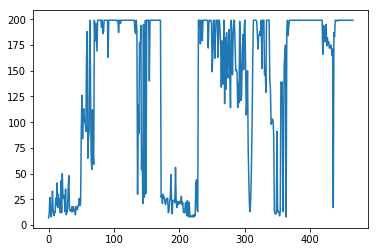

In [353]:
plt.plot(tt)

In [204]:
class toy():
    def __init__(self,n):
        self.n = n
        self.s = 0
        self.n_obs = self.n
        self.n_act = 2
    def reset(self):
        self.s = 0
        state_vec = np.zeros(self.n_obs)
        state_vec[0] = 1
        return state_vec
    def step(self,act):
        if act == 0:
            if self.s == self.n -1:
                next_s = 0
                reward = 100
            else:
                next_s = self.s + 1
                reward = -1
        elif act == 1:
            next_s = 0
            reward = 0
        self.s = next_s
        state_vec = np.zeros(self.n_obs)
        state_vec[next_s] = 1
        
        obs = state_vec
        done = False
        info = {}
        return obs,reward,done,info
        
        
        
        
    

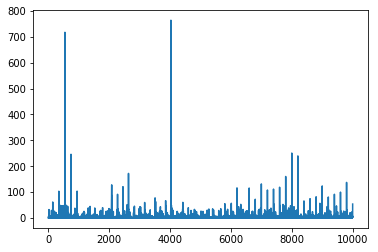

In [352]:
plt.plot(learner.memory.buffer_priority)

In [346]:
x = np.arange(-10,10)
qs = []
acs = []
for xx in x:
    q,a = learner.step([xx,0,0,0],explore = False)
    qs.append(q.data)
    acs.append(a)

In [347]:
qs = np.stack(qs)[:,0,:]

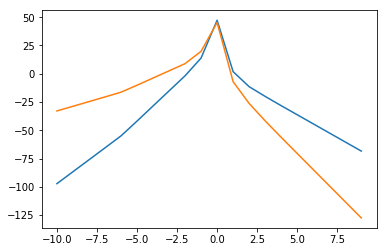

In [348]:
plt.plot(x,qs)

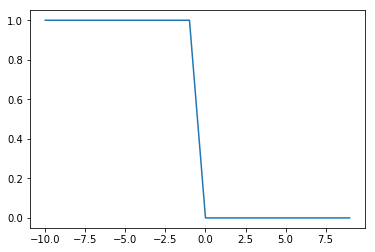

In [349]:
plt.plot(x,acs)